# Intro
In this brief analysis we are looking at the dataset of patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The dataset consists of about 58 thousand reviews. For simplicity, we will group the reviews by condition and then look at those with the largest number of reviews. [The dataset can be found here.](http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
sns.set(color_codes=True)

TAG_RE = re.compile(r'<[^>]+>')
SPAN_TAG_PATTERN = ".*</span>.*"

In [24]:
drugs = pd.read_csv("drugsComTest_raw.tsv", sep="\t", parse_dates=["date"])

In [32]:
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_drugs(drugs):
    # we need to filter out any condition that is HTML: contains </span> tag
    #drugs.condition = [TAG_RE.sub('', condition) for condition in drugs.condition]
    filter = drugs['condition'].str.contains(SPAN_TAG_PATTERN)
    drugs.condition = drugs.condition.astype("category")
    filter.fillna(False, inplace=True)
    drugs = drugs[~filter]
    return drugs

In [26]:
drugs = preprocess_drugs(drugs)

In [28]:
average_ratings = drugs.groupby(["condition"]).rating.mean()
df = average_ratings.to_frame().dropna()
number_of_reviews = drugs.groupby(["condition"]).size()
number_of_reviews = number_of_reviews[number_of_reviews>0].to_frame()
df.reset_index(inplace=True)
number_of_reviews.reset_index(inplace=True)
df = df.merge(number_of_reviews, on="condition")
df.columns = ["condition", "rating", "number_of_reviews"]
df.set_index("condition", inplace=True)

In [33]:
useful_reviews = drugs.groupby(["condition"]).usefulCount.sum()
useful_reviews = useful_reviews.to_frame()
useful_reviews.reset_index(inplace=True)
mask = useful_reviews.condition.str.contains(SPAN_TAG_PATTERN)
useful_reviews = useful_reviews[~mask]
df = df.merge(useful_reviews, on="condition")
devs = drugs.groupby(["condition"]).rating.aggregate(np.std).to_frame()
devs.reset_index(inplace=True)
df = df.merge(devs, on="condition")
df.columns = ["condition", "rating", "number_of_reviews", "useful_count", "standard_deviation"]
df["useful_per_review"] = df.useful_count / df.number_of_reviews

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


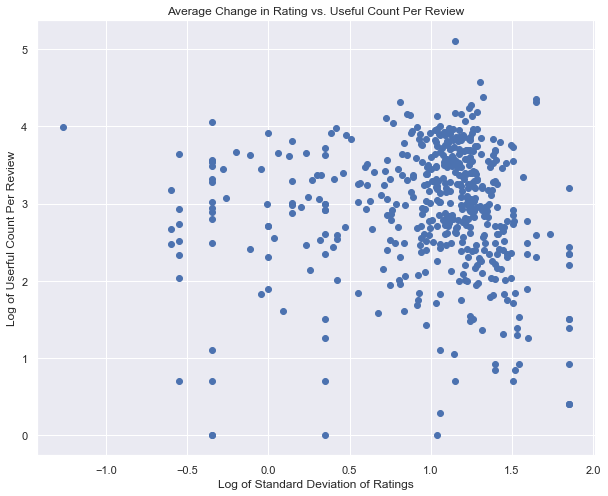

In [34]:
plt.figure(figsize=(10,8))
plt.scatter(x=np.log(df.standard_deviation), y=np.log(df.useful_per_review))
plt.title("Average Change in Rating vs. Useful Count Per Review")
plt.xlabel("Log of Standard Deviation of Ratings")
plt.ylabel("Log of Userful Count Per Review")
plt.show()

In [35]:
# lets look at the distribution of number_of_ratings
df.number_of_reviews.describe()
# now lets look at the distribution of useful_count
df.useful_count.describe()
# so lets only consider those drugs with at least 6 reviews, with at least 111 useful_count
mask = (df.number_of_reviews>=6) & (df.useful_count>=111)
drugs_top_rating = df[mask].sort_values(["rating"], ascending = False)
drugs_top_rating.set_index("condition", inplace=True)
drugs_top_rating["useful_per_review"] = drugs_top_rating.useful_count / drugs_top_rating.number_of_reviews
top_drugs_per_review = drugs_top_rating.sort_values(["useful_per_review"], ascending=False)

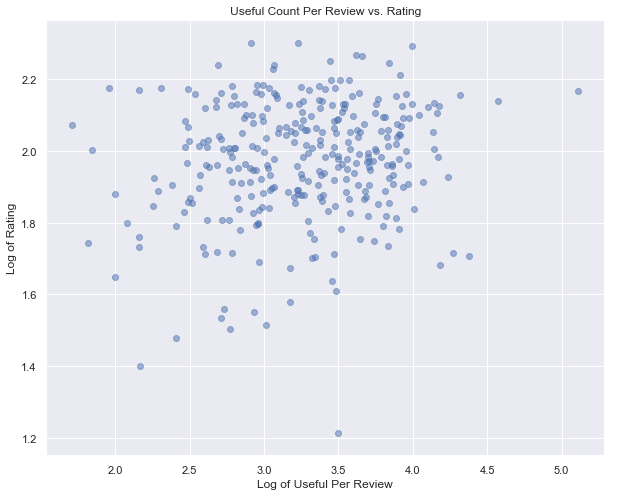

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(x=np.log(top_drugs_per_review.useful_per_review), y=np.log(top_drugs_per_review.rating), alpha=0.5)
plt.title("Useful Count Per Review vs. Rating")
plt.xlabel("Log of Useful Per Review")
plt.ylabel("Log of Rating")
plt.show()

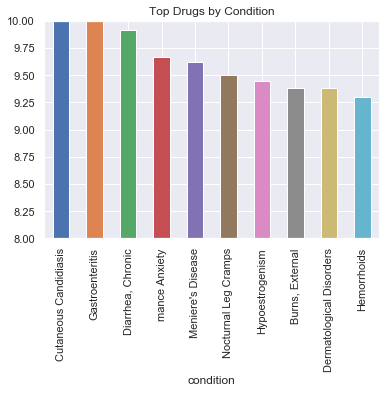

In [37]:
top_drugs_per_review.sort_values(["rating"], ascending=False).head(10).plot.bar(y="rating", ylim=(8,10), title = "Top Drugs by Condition", legend = False)

In [38]:
top_drugs_per_review.number_of_reviews.describe()
# lets filter out our dataframe to only look at those drugs with at least 105 reviews
# remember we are already filtering out the drugs that 
# have at least 6 reviews and at least 111 people found them useful
top_drugs_per_review.useful_per_review.describe()
# we also want to add the contraint that the drug has at least 38.75 useful reviews
mask = (top_drugs_per_review.number_of_reviews>=105) & (top_drugs_per_review.useful_per_review >= 38.75)
#top_drugs_per_review[mask] 
# so there are 23 drugs that meet this criteria

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


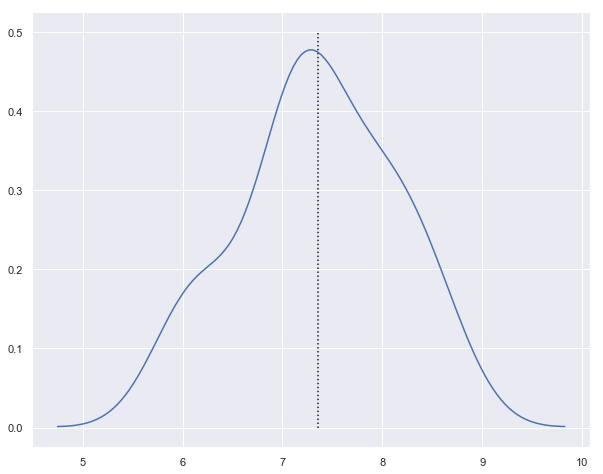

In [39]:
plt.figure(figsize=(10,8))
sns.kdeplot(top_drugs_per_review[mask].rating, legend=False)
plt.vlines(x=np.mean(top_drugs_per_review[mask].rating), ymin=-0, ymax=0.5, linestyles=[":"])
plt.show()

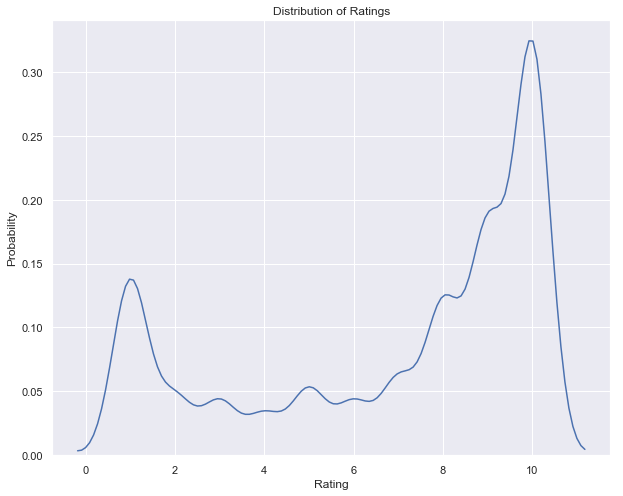

In [55]:
plt.figure(figsize=(10,8))
sns.kdeplot(drugs.rating, legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.show()

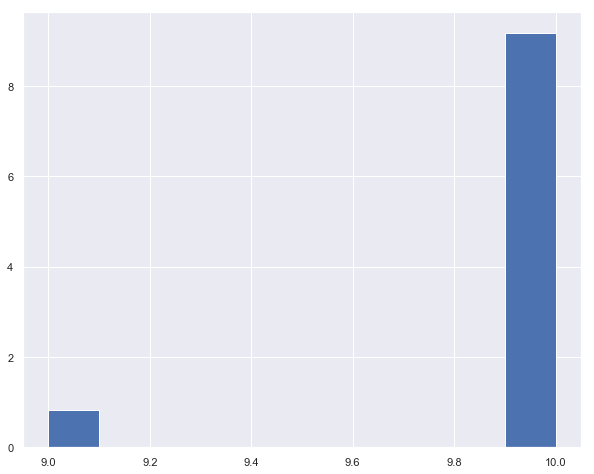

In [54]:
# just run a simple test/plot on Diarrhea, Chronic
diarrhea = drugs[drugs.condition=="Diarrhea, Chronic"]
plt.figure(figsize=(10,8))
plt.hist(diarrhea.rating, density=True)
plt.show()

In [55]:
len(top_drugs_per_review[mask])

23

# Notes
It is interesting to note that the distribution of all ratings appears to be bimodal, whereas if we take the top 23 drugs (based on the number of reviews and how useful each review is) demonstrates a normal distribution. This must be accounted for.  